## UMAP colored by technical labels

We show that a SynapseCLR model trained with dihedral rotations, in contrast to artitrary SO(3) rotations, exploits the orientation of the synaptic cleft plane to differentiate between synapses!

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from IPython.display import HTML
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation 
import numpy as np

import colorcet as cc
from collections import Counter

from sklearn.decomposition import PCA as SKPCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from synapse_utils import io

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

# these are pre-computed (can be set to None)
contamination_indices_path = os.path.join(
    checkpoint_path, 'indices', 'contamination_meta_df_row_indices.npy')
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

In [3]:
imputed_cell_types_df_path = '../../output/consensus/consensus__meta__uncensored.csv'
imputed_meta_ext_df_path = '../../output/gp/synapse_simclr_production/imputed_meta__rbf__synapse_simclr__ensemble.csv'

## 2D Embedding

In [4]:
import cuml
from cuml import PCA, TSNE, UMAP

embedding_2d_loaded = False

In [5]:
# # load features
load_prefix = 'projector.mlp.3'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = True

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

n_pca_components = 128
if n_pca_components < features_nf.shape[-1]:
    features_nf = PCA(n_components=n_pca_components).fit_transform(features_nf)

In [6]:
# (optionally) load
import pickle

embedding_type = 'UMAP'
features_n2 = np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'))

with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'rb') as f:
    loader = pickle.Unpickler(f)
    umap_2d_fit = loader.load()
    
embedding_2d_loaded = True

In [7]:
if not embedding_2d_loaded:
    
    embedding_type = 'UMAP'
    save_results = True

    # for UMAP
    n_neighbors = 500
    n_epochs = 5000
    learning_rate = 1.0
    spread = 1.0
    min_dist = 0.1

    # for t-SNE
    perplexity = 10


    if embedding_type == 'UMAP':

        umap_2d_fit = UMAP(
            min_dist=min_dist,
            spread=spread,
            n_neighbors=n_neighbors,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            random_state=42).fit(features_nf)

        features_n2 = umap_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'wb') as f:
                pickle.dump(umap_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'),
                features_n2)

    elif embedding_type == 'TSNE':

        tsne_2d_fit = TSNE(
            perplexity=perplexity,
            n_neighbors=n_neighbors,
            learning_rate_method=None).fit(features_nf)

        features_n2 = tsne_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d__fit.pkl'), 'wb') as f:
                pickle.dump(tsne_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d.npy'),
                features_n2)

## Overlay Annotations

In [8]:
from synapse_utils.commons import load_imputed_annotations, log1p_zscore

# helper function
def get_row_indices_from_synapse_ids(synapse_ids):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

In [9]:
# which annotations to use?
annotations_to_use = 'imputed'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()
    analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
    analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)
    output_subdir = 'manual/'

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)
    output_subdir = ''

In [10]:
analysis_synapse_ids = analysis_meta_ext_df['synapse_id'].values
analysis_indices = get_row_indices_from_synapse_ids(analysis_synapse_ids)

## Calculate cleft normal vector

In [11]:
from synapse_augmenter import consts as syn_consts

def get_cleft_plane_angle(mask_cxyz, X=None, Y=None, Z=None):

    # generate grid
    if X is None:
        final_img_size = mask_cxyz.shape[-1]
        X, Y, Z = np.mgrid[:final_img_size, :final_img_size, :final_img_size]
    
    # mask components
    mask_pre = mask_cxyz[syn_consts.MASK_PRE_SYNAPTIC_NEURON - 1]
    mask_post = mask_cxyz[syn_consts.MASK_POST_SYNAPTIC_NEURON - 1]
    mask_cleft = mask_cxyz[syn_consts.MASK_SYNAPTIC_CLEFT - 1]
    
    if np.sum(mask_cleft) < 1e-5:
        return np.asarray([1., 0., 0.]), False
        
    # cleft normal direction
    cleft_x = X[mask_cleft].flat
    cleft_y = Y[mask_cleft].flat
    cleft_z = Z[mask_cleft].flat
        
    cleft_points_n3 = np.vstack((cleft_x, cleft_y, cleft_z)).T
    
    cleft_pca = SKPCA(n_components=3).fit(cleft_points_n3 - np.mean(cleft_points_n3, axis=0, keepdims=True))
    cleft_normal = cleft_pca.components_[2]
    cleft_inplane_1 = cleft_pca.components_[0]
    cleft_inplane_2 = cleft_pca.components_[1]

    mask_pre_vol = 1e-6 + np.sum(mask_pre)
    mask_post_vol = 1e-6 + np.sum(mask_post)
    polarity = (
        (np.sum(X[mask_pre]) / mask_pre_vol - np.sum(X[mask_post]) / mask_post_vol) * cleft_normal[0] +
        (np.sum(Y[mask_pre]) / mask_pre_vol - np.sum(Y[mask_post]) / mask_post_vol) * cleft_normal[1] + 
        (np.sum(Z[mask_pre]) / mask_pre_vol - np.sum(Z[mask_post]) / mask_post_vol) * cleft_normal[2])
    if polarity < 0.:
        cleft_normal = (-1.) * cleft_normal

    return cleft_normal, True

In [12]:
import torch
from operator import itemgetter
from synapse_utils import vis
from tqdm.notebook import tqdm

ctx = vis.SynapseVisContext(
    dataset_path,
    '../../configs/config__synapseclr__so3__second_stage/augmenter_display.yaml',
    meta_df_override=meta_df,
    device='cuda')

batch_size = 16

train_loader = torch.utils.data.DataLoader(
    ctx.synapse_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=lambda x: x,  # do not collate; return as a list of np.ndarray
    num_workers=1,
    sampler=None,
    pin_memory=True)

In [13]:
cleft_normal_dict = dict()
cleft_normal_success_dict = dict()

In [ ]:
n_total_batches = int(np.ceil(len(meta_df) / batch_size))

final_img_size = 192
X, Y, Z = np.mgrid[:final_img_size, :final_img_size, :final_img_size]

with tqdm(total=n_total_batches) as t:
    
    for minibatch_data_bundle in train_loader:

        # update progressbar
        t.update()

        index_list = list(map(itemgetter(0), minibatch_data_bundle))
        intensity_mask_cxyz_list = list(map(itemgetter(1), minibatch_data_bundle))        
        intensity_bcxyz, mask_bcxyz = ctx.aug.augment_raw_data(intensity_mask_cxyz_list)
        mask_bcxyz = mask_bcxyz.cpu().numpy()
        
        for i_mb in range(mask_bcxyz.shape[0]):
            synapse_index = index_list[i_mb]
            mask_cxyz = mask_bcxyz[i_mb]
            cleft_normal, success = get_cleft_plane_angle(mask_cxyz, X=X, Y=Y, Z=Z)
            cleft_normal_dict[synapse_index] = cleft_normal
            cleft_normal_success_dict[synapse_index] = success

## Make the scatter plot

In [14]:
meta_df = pd.read_csv('../../tables/meta_cleft_normal.csv', index_col=0)

checkpoint_path_list = [
    '../../output/checkpoint__synapseclr__so3__second_stage',
    '../../output/checkpoint__synapseclr__dihedral'
]

checkpoint_path_labels = [
    'SO(3) Rotations',
    'Dihedral Rotations'
]

load_prefix = 'encoder.fc'
save_prefix = load_prefix.replace('.', '_')

feature_n2_list = []
for checkpoint_path in checkpoint_path_list:
    feature_n2_list.append(
        np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy')))

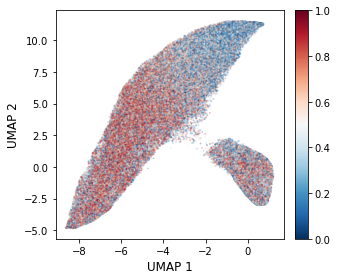

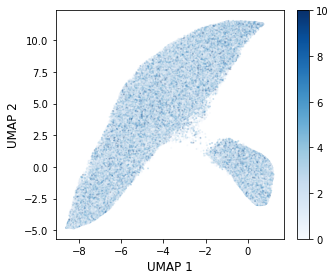

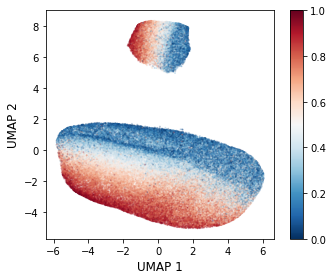

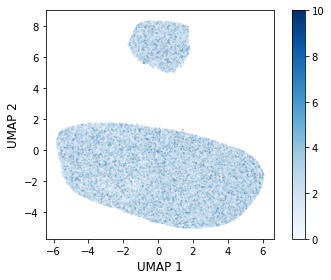

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

c_list = [
    np.abs(meta_df['cleft_normal_z'].values),
    meta_df['n_cutout_sections'].values
]

vrange_list = [
    (0., 1.),
    (0, 10)
]

cmap_list = [
    plt.cm.RdBu_r,
    plt.cm.Blues
]

for i in range(len(feature_n2_list)):
    for j in range(len(c_list)):
        
        label = checkpoint_path_labels[i]
        features_n2 = feature_n2_list[i]
        c = c_list[j]
        v_range = vrange_list[j]
        cmap = cmap_list[j]
        
        fig, ax = plt.subplots(figsize=(4.7, 4))
        
        sc = ax.scatter(
            features_n2[:, 0],
            features_n2[:, 1],
            s=1,
            alpha=0.2,
            c=c,
            cmap=cmap,
            vmin=v_range[0],
            vmax=v_range[1],
            rasterized=True)
    
        ax.set_box_aspect(1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
        cbar.set_alpha(1.)
        cbar.draw_all()

        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')

        fig.tight_layout()
        fig.savefig(f'../../output/analysis/umap_technical/umap__{i}_{j}.pdf', dpi=200)